# Test application of ML classifier to data

Takes pickled traing sklearn model and applies to data from DEA

Model is trained using data extracted to a CSV file, can be downloaded from: https://rsg.pml.ac.uk/shared_files/dac/train_input_geomedian_tmad_subset.txt.gz

The model is trained using [train_ml_model](train_ml_model.ipynb)

In [39]:
import os
import pickle
import sys

import datacube
from datacube import helpers
from datacube.utils import geometry
from matplotlib import pyplot
import numpy
import sklearn
import xarray
import yaml


# Load in modules from repos
sys.path.append('/home/jovyan/development/LCCS/decision_tree')
import dea_classificationtools

sys.path.append('/home/jovyan/development/dea-notebooks/Scripts')
from dea_bandindices import calculate_indices
from dea_plotting import display_map

sys.path.append('/home/jovyan/development/livingearth_lccs')
from le_lccs.le_classification import lccs_l3

In [13]:
# Set up working dir
working_dir = '/home/jovyan/cultivated_classification'

In [40]:
# Load in pickled data. Pickle dictionary with model variables
# and model so don't get confused with which variables are being
# used
with open(os.path.join(working_dir, 'model_pickle.pickle'), 'rb') as f:
    ml_model_dict = pickle.load(f)
    
classifier = ml_model_dict['classifier']
model_variable_names = ml_model_dict['variables']

# Prediction

In [33]:
def run_classification_for_site(site_name, classifier, model_variable_names=None):
    """
    Function to run the classification for a given site.
    
    Gets bounds of site from yaml file
    """
    # Specify site

    # Read in config file with site bounds
    with open("au_test_sites.yaml", "r") as f:
        config = yaml.safe_load(f)
    
    # Get bounds
    x = (config[site_name]["min_x"],config[site_name]["max_x"])
    y = (config[site_name]["max_y"],config[site_name]["min_y"])

    query = {'time': ('2015-01-01', '2015-02-01')}
    query['x'] = x
    query['y'] = y
    query['crs'] = 'EPSG:3577'
    query['resolution'] = (-100, 100)
    
    dc = datacube.Datacube(app = 'classifiers')

    geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day',
                             dask_chunks={'x' : 1000, 'y' : 1000}, **query)
    
    
    geomedian_data = calculate_indices(geomedian_data, 'BUI', collection='ga_ls_2')
    geomedian_data = calculate_indices(geomedian_data, 'BSI', collection='ga_ls_2')
    geomedian_data = calculate_indices(geomedian_data, 'NBI', collection='ga_ls_2')
    geomedian_data = calculate_indices(geomedian_data, 'EVI', collection='ga_ls_2')
    geomedian_data = calculate_indices(geomedian_data, 'NDWI', collection='ga_ls_2')
    geomedian_data = calculate_indices(geomedian_data, 'MSAVI', collection='ga_ls_2')
    
    mads_data = dc.load(product='ls8_nbart_tmad_annual', group_by='solar_day',
                        dask_chunks={'x' : 1000, 'y' : 1000}, **query)

    # Join geomedian + mads
    new_data = xarray.merge([geomedian_data, mads_data])
    
    # Subset to just use the variable names from the model
    if model_variable_names is not None:
        new_data = new_data[model_variable_names]
        
    predicted = dea_classificationtools.predict_xr(classifier, new_data, progress=True)
    
    return predicted

## Run for a single site and plot outputs

In [41]:
site_name = 'Kakadu'
predicted = run_classification_for_site(site_name, classifier=classifier,
                                        model_variable_names=model_variable_names)

[                                        ] | 0% Completed |  0.1s

/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[########################################] | 100% Completed | 13.5s


In [42]:
red, green, blue, alpha = lccs_l3.colour_lccs_level3(predicted[0])

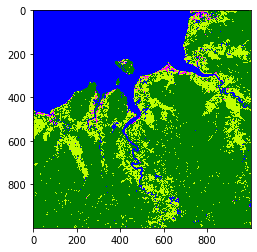

In [43]:
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

### Loop thorough all site and export a geotiff

In [ ]:
with open("au_test_sites.yaml", "r") as f:
    config = yaml.safe_load(f)

In [ ]:
for i, site_name in enumerate(config.keys()):
    
    print("[{:02}/{:02}] {}".format(i+1, len(config.keys()),site_name))
    
    predicted = run_classification_for_site(site_name, model_variable_names=model_variable_names)
    
    # Get only cultivated layer
    cultivated = predicted.where(predicted == 111)

    out = cultivated.isel(time=0).transpose()
    out = cultivated.to_dataset(name="cultivated")
    out.attrs['crs']=geometry.CRS(geomedian_data.crs)
    out = out.isel(time=0)
    
    helpers.write_geotiff(os.path.join(working_dir, '{}_cultivated.tif'.format(site_name.lower().replace(' ','_'))),
                          out)